## Задание 1. Исследовать GAN для генерации точек на параболе

1.1
* Посмотреть что будет если подавать в качестве шума uniform распределение
    * **Должно стать чуть хуже, парабола получится за N=5 эпох менее гладкой**
* Попробовать избавится от линейности на параболе (любыми известными методами)
    * **Делается это заменой ReLU на SiLU (или любую гладкую вроде tanh)**

1.2
* Сделать генерацию фигуры более сложной формы, например круга
    * **Нужно изменить функцию генерирующую пару точек x,y**
* Добится сходимости
    * **Если не сиьно менять параметры, то получится довольно быстро**
* Желательно сделать гиф-анимацию/видео какие точки выдаёт в процессе обучения

1.3
* Предобучить только дискриминатор (сделать его сильным критиком).
* Обучать только генератор (если критик достаточно сильный, то генератор не будет учиться)

    * **В зависимости от того, сколько эпох учился дискриминатор могут получиться следующие результаты:**
        * **Если дискриминатор получился сильным, то генератору будет сложно и фигура долго не будет сходится. То есть генератор не может побороть слишком хороший дискриминатор.**
        * **Если дискриминатор получился недостаточно сильным, то это может помочь сходимости и фигура может сойтись даже быстрее, чем при одновременном обучении D и G с самого начала.**

In [1]:
import os
import numpy as np
import math
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from IPython.display import clear_output
from PIL import Image

import torch
import torch.nn as nn
from torch import autograd
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import Dataset, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
from torchvision.utils import save_image

device = "cuda"

Определяем модели:

In [ ]:
class GenModel(nn.Module):
    def __init__(self, latent_space):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_space, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50,2))

    def forward(self, x):
        return self.model(x)

In [ ]:
class DisModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 25),
            nn.ReLU(),
            nn.Linear(25, 15),
            nn.ReLU(),
            nn.Linear(15,1),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)

In [ ]:
def get_g_batch(batch_size, latent_dim):
    g_input = torch.randn(size=(batch_size, latent_dim)).to(device)
    # g_input = torch.rand(size=(batch_size, latent_dim)).to(device)
    labels = torch.ones(size=(batch_size,)).to(device)
    return g_input, labels

In [ ]:
def make_r(a=0.81, b=0.14, c=2, phi=torch.linspace(0, 2*np.pi, 100), n=1):
    r = 0.1 + 1/c * torch.sqrt(-torch.log(2*np.exp(-a**2) - torch.exp(-b**2 * torch.sin((phi-np.pi/2)*n/2)**2)))
    x = r*torch.cos(phi)
    y = r*torch.sin(phi)
    return x, y

In [ ]:
def get_mix_batch_normal(batch_size, latent_dim, netG):
    types_of_points = []
    
    # Generate true pairs and true labels
    x = torch.distributions.Uniform(-1, +1).sample((batch_size,)).to(device)
    true_pair = torch.vstack((x, x*x)).T.to(device)
    
    true_labels = torch.ones(size=(batch_size,)).unsqueeze(1).to(device)
    types_of_points.append(torch.hstack((true_pair, true_labels)))
    
    # Generate fake uniform pairs and fake labels
    x_fake = torch.distributions.Uniform(-1, +1).sample((batch_size,)).to(device)
    y_fake = torch.distributions.Uniform(-1, +1).sample((batch_size,)).to(device)
    fake_pair = torch.vstack((x_fake, y_fake)).T
    fake_labels = torch.zeros(size=(batch_size,)).unsqueeze(1).to(device)
    types_of_points.append(torch.hstack((fake_pair, fake_labels)))

    # Generate points from generator and set labels as fake
    gan_pair = netG(torch.randn(size=(batch_size, latent_dim)).to(device)) # Normal distribution
    gan_labels = torch.zeros(size=(batch_size,)).unsqueeze(1).to(device)
    types_of_points.append(torch.hstack((gan_pair, gan_labels)))
    
    # Stack all types of points
    z = torch.vstack(types_of_points)
    # Shuffle
    z=z[torch.randperm(z.size()[0])]
    
    # Split back to samples and labels
    mixed_pairs = z[:, :2]
    mixed_labels = z[:, 2]
    return mixed_pairs, mixed_labels

In [ ]:
def get_test_loss(model,test_loader,loss_function):
    with torch.no_grad():
        loss_test_total = 0
        for samples, labels in test_loader:
            outputs = model(samples.to(device))
            loss = loss_function(outputs, labels.to(device))
            loss_test_total += loss.item()
        return loss_test_total/len(test_loader)

In [ ]:
def netD_step(netD, batchD, loss_func, optimizer):
    samples, labels = batchD
    optimizer.zero_grad()
    outputs = netD(samples.to(device))
    loss = loss_func(outputs.to(device), labels.unsqueeze(1).detach().to(device))
    loss.backward()
    optimizer.step()

In [ ]:
def netG_step(netD, netG, batchG, loss_func, optimizer):
    samples, labels = batchG
    optimizer.zero_grad()
    outputs = netD(netG(samples.to(device)))
    loss = loss_func(outputs.to(device), labels.unsqueeze(1).detach().to(device))
    loss.backward()
    optimizer.step()

In [ ]:
def plot_gen(netG, epoch="Not provided", title = '', limits=[-1,1,-1,1]):
    Gin, _ = get_g_batch(1000, latent_dim)
    out = netG(Gin).cpu()
    plt.scatter(out.detach().numpy()[:, 0], out.detach().numpy()[:, 1], color="blue", s=1)
    plt.title(f'[Epoch={epoch+1}] {title}', fontsize=10)
    plt.axis([-1,1,-1,1])
    plt.show()

In [ ]:
def train(netD, netG, batch_per_epoch, batch_size, latent_dim, epochs, loss_func, optD, optG):
    for epoch in range(epochs):
        for _ in range(batch_per_epoch):
            batchG = get_g_batch(batch_size, latent_dim)
            batchD = get_mix_batch(batch_size, latent_dim, netG)
            
            netD.train(True)
            netG.train(False)
            netD_step(netD, batchD, loss_func, optD)
            
            netD.train(False)
            netG.train(True)
            netG_step(netD, netG, batchG, loss_func, optG)
            
        # clear_output()
        plot_gen(netG, epoch)

### 1.1 Решение:

**Посмотреть что будет если подавать в качестве шума uniform распределение**

In [ ]:
def get_mix_batch_uniform(batch_size, latent_dim, netG):
    types_of_points = []
    
    # Generate true pairs and true labels
    x = torch.distributions.Uniform(-1, +1).sample((batch_size,)).to(device)
    true_pair = torch.vstack((x, x*x)).T.to(device)

    true_labels = torch.ones(size=(batch_size,)).unsqueeze(1).to(device)
    types_of_points.append(torch.hstack((true_pair, true_labels)))
    
    # Generate fake uniform pairs and fake labels
    x_fake = torch.distributions.Uniform(-1, +1).sample((batch_size,)).to(device)
    y_fake = torch.distributions.Uniform(-1, +1).sample((batch_size,)).to(device)
    fake_pair = torch.vstack((x_fake, y_fake)).T
    fake_labels = torch.zeros(size=(batch_size,)).unsqueeze(1).to(device)
    types_of_points.append(torch.hstack((fake_pair, fake_labels)))

    # Generate points from generator and set labels as fake
    gan_pair = netG(torch.rand(size=(batch_size, latent_dim)).to(device)) # Меняем randn на rand
    gan_labels = torch.zeros(size=(batch_size,)).unsqueeze(1).to(device)
    types_of_points.append(torch.hstack((gan_pair, gan_labels)))
    
    # Stack all types of points
    z = torch.vstack(types_of_points)
    # Shuffle
    z=z[torch.randperm(z.size()[0])]
    
    # Split back to samples and labels
    mixed_pairs = z[:, :2]
    mixed_labels = z[:, 2]
    return mixed_pairs, mixed_labels

In [ ]:
latent_dim = 5
batch_size = 128
batch_per_epoch = 1000
epochs = 5

netG = GenModel(latent_dim).to(device)
netD = DisModel().to(device)
loss_func = nn.BCELoss().to(device)
optD = torch.optim.Adam(netD.parameters(), lr=0.001)
optG = torch.optim.Adam(netG.parameters(), lr=0.001)

In [ ]:
get_mix_batch = get_mix_batch_uniform
train(netD, netG, batch_per_epoch, batch_size, latent_dim, epochs, loss_func, optD, optG)
get_mix_batch = get_mix_batch_normal # Back to normal

**Попробовать избавится от линейности на параболе (любыми известными методами)**

In [ ]:
# Меняем активации на гладкие
class GenModelSiLU(nn.Module):
    def __init__(self, latent_space):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_space, 50),
            nn.SiLU(),
            nn.Linear(50, 50),
            nn.SiLU(),
            nn.Linear(50,2))

    def forward(self, x):
        return self.model(x)

class DisModelSiLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 25),
            nn.SiLU(),
            nn.Linear(25, 15),
            nn.SiLU(),
            nn.Linear(15,1),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)

In [ ]:
latent_dim = 5
batch_size = 128
batch_per_epoch = 1000
epochs = 6

netG = GenModelSiLU(latent_dim).to(device)
netD = DisModelSiLU().to(device)
loss_func = nn.BCELoss().to(device)
optD = torch.optim.Adam(netD.parameters(), lr=0.001)
optG = torch.optim.Adam(netG.parameters(), lr=0.001)

train(netD, netG, batch_per_epoch, batch_size, latent_dim, epochs, loss_func, optD, optG)

### 1.2 Решение:

**Сделать генерацию фигуры более сложной формы, например круга**

In [ ]:
def get_mix_batch_figure(batch_size, latent_dim, netG):
    types_of_points = []
    
    # Generate true pairs and true labels
    # Создаем новую форму (Круг)
    t = torch.distributions.Uniform(0, 2*math.pi).sample((batch_size,))
    x = torch.sin(t)
    y = torch.cos(t)

    x = x.to(device)
    y = y.to(device)
    true_pair = torch.vstack((x, y)).T
    
    true_labels = torch.ones(size=(batch_size,)).unsqueeze(1).to(device)
    types_of_points.append(torch.hstack((true_pair, true_labels)))
    
    # Generate fake uniform pairs and fake labels
    if True:
        x_fake = torch.distributions.Uniform(-1, +1).sample((batch_size,)).to(device)
        y_fake = torch.distributions.Uniform(-1, +1).sample((batch_size,)).to(device)
        fake_pair = torch.vstack((x_fake, y_fake)).T
        fake_labels = torch.zeros(size=(batch_size,)).unsqueeze(1).to(device)
        types_of_points.append(torch.hstack((fake_pair, fake_labels)))

    # Generate points from generator and set labels as fake
    if True:
        gan_pair = netG(torch.randn(size=(batch_size, latent_dim)).to(device))
        gan_labels = torch.zeros(size=(batch_size,)).unsqueeze(1).to(device)
        types_of_points.append(torch.hstack((gan_pair, gan_labels)))
    
    # Stack all types of points
    z = torch.vstack(types_of_points)
    # Shuffle
    z=z[torch.randperm(z.size()[0])]
    
    # Split back to samples and labels
    mixed_pairs = z[:, :2]
    mixed_labels = z[:, 2]
    return mixed_pairs, mixed_labels

In [ ]:
latent_dim = 5
batch_size = 128
batch_per_epoch = 1000
epochs = 12

netG = GenModel(latent_dim).to(device)
netD = DisModel().to(device)
loss_func = nn.BCELoss().to(device)
optD = torch.optim.Adam(netD.parameters(), lr=0.001)
optG = torch.optim.Adam(netG.parameters(), lr=0.001)

get_mix_batch = get_mix_batch_figure
train(netD, netG, batch_per_epoch, batch_size, latent_dim, epochs, loss_func, optD, optG)

**Гиф-анимация генерируемых точек в процессе обучения**

In [ ]:
!apt install imagemagick #Ставим imagemagick
clear_output()

### 1.3 Решение:

**Предобучить только дискриминатор (сделать его сильным критиком) и посмотреть будет ли сходится генератор**

In [ ]:
def train(netD, netG, batch_per_epoch, batch_size, latent_dim, epochs, loss_func, optD, optG, learn_only_D=False, learn_only_G=False):
    for epoch in range(epochs):
        for _ in range(batch_per_epoch):
            if not learn_only_G:
                batchD = get_mix_batch(batch_size, latent_dim, netG)
                netD.train(True)
                netG.train(False)
                netD_step(netD, batchD, loss_func, optD)
            
            if not learn_only_D:
                batchG = get_g_batch(batch_size, latent_dim)
                netD.train(False)
                netG.train(True)
                netG_step(netD, netG, batchG, loss_func, optG)
                
        if learn_only_D:
            clear_output()
            print(f'Current epoch={epoch}')
        if learn_only_G:
            plot_gen(netG, epoch, title = f"learn_only_G = {learn_only_G}")

netG = GenModel(latent_dim).to(device)
netD = DisModel().to(device)
loss_func = nn.BCELoss().to(device)
optD = torch.optim.Adam(netD.parameters(), lr=0.001)
optG = torch.optim.Adam(netG.parameters(), lr=0.001)


get_mix_batch = get_mix_batch_normal
# Обучаем только дискриминатор, делая его сильным
train(netD, netG, batch_per_epoch, batch_size, latent_dim, 50,
      loss_func, optD, optG, learn_only_D=True, learn_only_G=False)
# Продолжаем обучать в обычном режиме
train(netD, netG, batch_per_epoch, batch_size, latent_dim, 10,
      loss_func, optD, optG, learn_only_D=False, learn_only_G=True)

## Задание 2. cGAN на датасете Fashion mnist (или MNIST)

Напишите полносвязный GAN с условием. Условием в данном случае будет являтся lablel (номер класса) цифры или вещи.

1. Сделайте эмбединг для лэйблов внутри модели
2. С помощью torch.cat добавьте этот эмбединг ко входу генератора и дискриминатора
3. Используйте такие параметры для генератора:
        self.model = nn.Sequential(
            nn.Linear(?, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
        
4. Используйте такую архитектуру для дискриминатора:
        self.model = nn.Sequential(
            nn.Linear(?, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

In [146]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.dense = nn.Sequential(
            nn.Linear(110, 49),
            nn.Tanh()
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1, out_channels=4, kernel_size=3),
            nn.LeakyReLU(0.1, inplace=True),
            nn.ConvTranspose2d(in_channels=4, out_channels=8, kernel_size=5, stride=2),
            nn.LeakyReLU(0.1, inplace=True),
            nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=4),
            nn.LeakyReLU(0.1, inplace=True),
            nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.LeakyReLU(0.1, inplace=True),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3),
            nn.LeakyReLU(0.1, inplace=True)
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        
        dense_in = torch.cat([z, c], 1)
        # print("dense_in", dense_in.shape)
        x = self.dense(dense_in)
        # print("x", x.shape)
        
        deconv_in = x.view(x.size(0), 7, 7).unsqueeze(1)
        out = self.deconv(deconv_in).squeeze()
        # print("out", out.shape)
        
        return out.view(x.size(0), 28, 28)

In [147]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        #Делаем эмбед label
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

Код ниже желательно не изменять

In [148]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5), std=(0.5))
])

dataset = FashionMNIST(root ='/content/',
                       train = True,
                       transform = transform, 
                       target_transform = None, 
                       download = True)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
clear_output()

In [149]:
def get_class_name(num):
    """Вспомогательная функция возвращающая название класса по его индексу
    num - численный индекс класса"""
    class_names = dataset.class_to_idx #{название класса : индекс класса}

    key_list = list(class_names.keys())
    val_list = list(class_names.values())
    
    # print key with val 100
    position = val_list.index(num)
    print(key_list[position])

In [150]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = torch.randn(batch_size, 100).to(device)
    fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size)).to(device)
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, torch.ones(batch_size).to(device))
    g_loss.backward()
    g_optimizer.step()
    return g_loss

def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, torch.ones(batch_size).to(device))
    # train with fake images
    z = torch.randn(batch_size, 100).to(device)
    fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size)).to(device)
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, torch.zeros(batch_size).to(device))

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss

In [151]:
def show_gen_res(generator):
    z = torch.randn(9, 100).to(device)
    labels = torch.LongTensor(np.arange(9)).to(device)

    sample_images = generator(z, labels).unsqueeze(1).data.cpu()

    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

In [152]:
betas = (0.5, 0.999)

generator = Generator().to(device)
discriminator = Discriminator().to(device)
lr = 1e-4

criterion = nn.BCELoss().to(device)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)

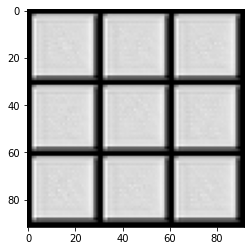

Starting epoch 0...
g_loss: 9.061105728149414, d_loss: 0.0002092619688482955


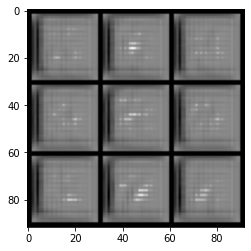

Starting epoch 1...
g_loss: 12.376590728759766, d_loss: 0.00118838413618505


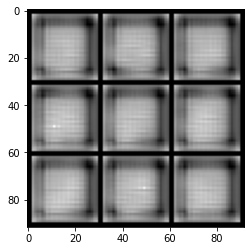

Starting epoch 2...
g_loss: 9.767539978027344, d_loss: 0.007399383466690779


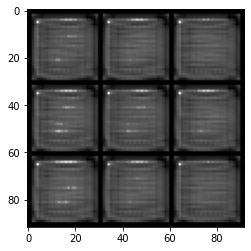

Starting epoch 3...
g_loss: 8.46120834350586, d_loss: 0.00312588969245553


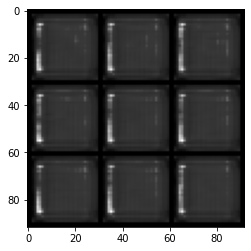

Starting epoch 4...
g_loss: 7.408491134643555, d_loss: 0.0027288529090583324


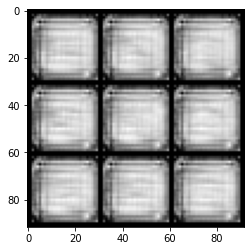

Starting epoch 5...
g_loss: 8.037068367004395, d_loss: 0.0028924639336764812


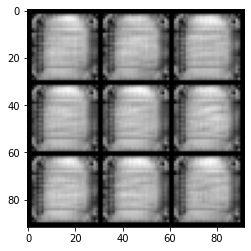

Starting epoch 6...
g_loss: 8.145965576171875, d_loss: 0.0011834565084427595


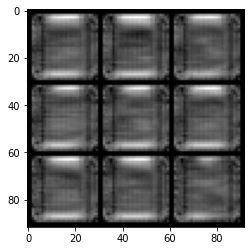

Starting epoch 7...
g_loss: 5.651068687438965, d_loss: 0.015470488928258419


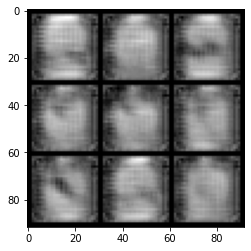

Starting epoch 8...
g_loss: 5.841831684112549, d_loss: 0.014583245851099491


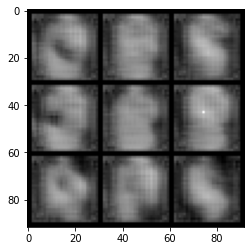

Starting epoch 9...
g_loss: 6.600285530090332, d_loss: 0.05192340910434723


In [153]:
num_epochs = 10
n_critic = 5
display_step = 300

for epoch in range(num_epochs):
    show_gen_res(generator)
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = images.to(device)
        labels = labels.to(device)
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
